In [ ]:
# pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# souce : https://api.alternative.me/fng/?limit=0&format=csv

In [ ]:
import requests

def fetch_fear_and_greed_index():
    url = "https://api.alternative.me/fng/"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        return data
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the Fear and Greed Index: {e}")
        return None

# Fetch the latest Fear and Greed Index data
index_data = fetch_fear_and_greed_index()

if index_data is not None:
    print("Latest Fear and Greed Index Data:")
    for item in index_data.get("data", []):
        value = item.get("value")
        classification = item.get("value_classification")
        print(f"Value: {value}, Classification: {classification}")
else:
    print("Failed to fetch the Fear and Greed Index data.")


Latest Fear and Greed Index Data:
Value: 79, Classification: Extreme Greed


In [ ]:
import pandas as pd
import requests
from io import StringIO

# The URL of the CSV file
url = 'https://api.alternative.me/fng/?limit=0&format=csv'

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Decode the content of the response
    content = response.content.decode('utf-8')
else:
    print("Failed to retrieve the CSV file")


In [ ]:
import pandas as pd
import re

# Using regular expressions to find all date, value, and classification entries
matches = re.findall(r'(\d{2}-\d{2}-\d{4}),(.*?),(Extreme Greed|Greed|Fear|Neutral)', content)

# Creating a DataFrame from the matches
df = pd.DataFrame(matches, columns=['date', 'fng_value', 'fng_classification'])

df.head()  # Displaying the first few rows of the DataFrame

,date,fng_value,fng_classification
0,02-04-2024,79,Extreme Greed
1,01-04-2024,79,Extreme Greed
2,31-03-2024,75,Greed
3,30-03-2024,75,Greed
4,29-03-2024,79,Extreme Greed


In [ ]:
df.date

0       02-04-2024
1       01-04-2024
2       31-03-2024
3       30-03-2024
4       29-03-2024
           ...    
1717    09-02-2018
1718    08-02-2018
1719    07-02-2018
1720    03-02-2018
1721    01-02-2018
Name: date, Length: 1722, dtype: object

In [ ]:
from datetime import datetime, timedelta

# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Define the date range
start_date = datetime.strptime('01-02-2018', '%d-%m-%Y')
end_date = datetime.strptime('02-04-2024', '%d-%m-%Y')

# Create a complete date range
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Convert the all_dates to a DataFrame
df_all_dates = pd.DataFrame(all_dates, columns=['date'])

# Merge the complete date range with our data - this will show NaN where data is missing
df_merged = df_all_dates.merge(df, on='date', how='left')

# Find dates with null values (where fng_value is NaN)
missing_dates = df_merged[df_merged['fng_value'].isnull()]

missing_dates

,date,fng_value,fng_classification
1,2018-02-02,NaN,NaN
3,2018-02-04,NaN,NaN
4,2018-02-05,NaN,NaN
5,2018-02-06,NaN,NaN
54,2018-03-27,NaN,NaN
...,...,...,...
1771,2022-12-08,NaN,NaN
1794,2022-12-31,NaN,NaN
1801,2023-01-07,NaN,NaN
1802,2023-01-08,NaN,NaN


In [ ]:
df_merged

,date,fng_value,fng_classification
0,2018-02-01,30,Fear
1,2018-02-02,NaN,NaN
2,2018-02-03,40,Fear
3,2018-02-04,NaN,NaN
4,2018-02-05,NaN,NaN
...,...,...,...
2248,2024-03-29,79,Extreme Greed
2249,2024-03-30,75,Greed
2250,2024-03-31,75,Greed
2251,2024-04-01,79,Extreme Greed


In [ ]:
# Calculate the mean of 'fng_value' for each month and replace NaN values with the corresponding monthly mean
df_merged['fng_value'] = df_merged['fng_value'].astype(float)
df_merged['month_year'] = df_merged['date'].dt.to_period('M')

df_filled = df_merged.copy()
df_filled['fng_value'] = df_filled.groupby('month_year')['fng_value'].transform(lambda x: x.fillna(x.mean()))

df_filled = df_filled.drop('month_year', axis=1)

df_filled.head()

,date,fng_value,fng_classification
0,2018-02-01,30.000000,Fear
1,2018-02-02,47.333333,NaN
2,2018-02-03,40.000000,Fear
3,2018-02-04,47.333333,NaN
4,2018-02-05,47.333333,NaN


In [ ]:
global_median = df_merged['fng_value'].median()

df_filled['fng_value'] = df_filled['fng_value'].fillna(global_median)

df_filled[df_filled['fng_value'].isnull()]

,date,fng_value,fng_classification


In [ ]:
df_fear_index = df_filled.drop(columns=['fng_classification'])
df_fear_index.head()

,date,fng_value
0,2018-02-01,30.000000
1,2018-02-02,47.333333
2,2018-02-03,40.000000
3,2018-02-04,47.333333
4,2018-02-05,47.333333


### Merge with the original data

In [ ]:
df = pd.read_csv('/content/Bitcoin Historical Data3 2 (1).csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,03/10/2024,"69,437.1","68,360.7","69,676.4","68,250.3",37.43K,1.57%
1,03/09/2024,"68,366.5","68,178.5","68,576.9","67,923.9",30.71K,0.29%
2,03/08/2024,"68,172.0","66,854.4","69,904.0","66,170.7",112.67K,1.97%
3,03/07/2024,"66,855.3","66,074.6","67,985.5","65,602.6",77.47K,1.17%
4,03/06/2024,"66,080.4","63,794.7","67,604.9","62,848.7",117.91K,3.59%


In [ ]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-10,"69,437.1","68,360.7","69,676.4","68,250.3",37.43K,1.57%
1,2024-03-09,"68,366.5","68,178.5","68,576.9","67,923.9",30.71K,0.29%
2,2024-03-08,"68,172.0","66,854.4","69,904.0","66,170.7",112.67K,1.97%
3,2024-03-07,"66,855.3","66,074.6","67,985.5","65,602.6",77.47K,1.17%
4,2024-03-06,"66,080.4","63,794.7","67,604.9","62,848.7",117.91K,3.59%
...,...,...,...,...,...,...,...
4980,2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%
4981,2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%
4982,2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%
4983,2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%


In [ ]:
merged_df =  df.merge(df_filled, left_on='Date', right_on='date', how='left')

merged_df = merged_df.drop('date', axis=1)

merged_df.head()


,Date,Price,Open,High,Low,Vol.,Change %,fng_value,fng_classification
0,2024-03-10,"69,437.1","68,360.7","69,676.4","68,250.3",37.43K,1.57%,79.0,Extreme Greed
1,2024-03-09,"68,366.5","68,178.5","68,576.9","67,923.9",30.71K,0.29%,84.0,Extreme Greed
2,2024-03-08,"68,172.0","66,854.4","69,904.0","66,170.7",112.67K,1.97%,81.0,Extreme Greed
3,2024-03-07,"66,855.3","66,074.6","67,985.5","65,602.6",77.47K,1.17%,82.0,Extreme Greed
4,2024-03-06,"66,080.4","63,794.7","67,604.9","62,848.7",117.91K,3.59%,75.0,Greed


In [ ]:
merged_df[merged_df['fng_value'].isnull()]

,Date,Price,Open,High,Low,Vol.,Change %,fng_value,fng_classification
2230,2018-01-31,"10,265.4","10,166.3","10,397.7","9,742.2",208.47K,0.98%,NaN,NaN
2231,2018-01-30,"10,166.0","11,244.5","11,277.2","9,917.7",264.72K,-9.59%,NaN,NaN
2232,2018-01-29,"11,244.8","11,794.9","11,888.1","11,119.0",137.42K,-4.67%,NaN,NaN
2233,2018-01-28,"11,795.1","11,471.2","12,112.7","11,433.3",154.63K,2.86%,NaN,NaN
2234,2018-01-27,"11,467.5","11,118.0","11,621.7","10,908.4",163.49K,3.14%,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4980,2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,NaN,NaN
4981,2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,NaN,NaN
4982,2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,NaN,NaN
4983,2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,NaN,NaN


In [ ]:
adjusted_df = merged_df[merged_df['Date'] > '2018-01-31']
adjusted_df = adjusted_df.drop(columns=['fng_classification'])
adjusted_df.head()

,Date,Price,Open,High,Low,Vol.,Change %,fng_value
0,2024-03-10,"69,437.1","68,360.7","69,676.4","68,250.3",37.43K,1.57%,79.0
1,2024-03-09,"68,366.5","68,178.5","68,576.9","67,923.9",30.71K,0.29%,84.0
2,2024-03-08,"68,172.0","66,854.4","69,904.0","66,170.7",112.67K,1.97%,81.0
3,2024-03-07,"66,855.3","66,074.6","67,985.5","65,602.6",77.47K,1.17%,82.0
4,2024-03-06,"66,080.4","63,794.7","67,604.9","62,848.7",117.91K,3.59%,75.0


In [ ]:
df = adjusted_df.copy()

In [ ]:
df.columns = ['date', 'close', 'open', 'high', 'low', 'vol', 'change', 'fg_index']

### 2-1. Convert object to numberic value

In [ ]:
def percentage_to_decimal(s):
    return float(s.strip('%')) / 100

In [ ]:
def convert_volume(volume):

    volume_str = str(volume)

    if 'K' in volume_str:
        return float(volume_str.replace('K', '')) * 1e3
    elif 'M' in volume_str:
        return float(volume_str.replace('M', '')) * 1e6
    elif 'B' in volume_str:
        return float(volume_str.replace('B', '')) * 1e9
    else:
        return float(volume_str)

In [ ]:
df['vol'] = df['vol'].apply(convert_volume)
df['close'] = df['close'].replace(',', '', regex=True).astype(float)
df['open'] = df['open'].replace(',', '', regex=True).astype(float)
df['high'] = df['high'].replace(',', '', regex=True).astype(float)
df['low'] = df['low'].replace(',', '', regex=True).astype(float)
df['change'] = df['change'].apply(percentage_to_decimal)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2230 entries, 0 to 2229
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2230 non-null   datetime64[ns]
 1   close     2230 non-null   float64       
 2   open      2230 non-null   float64       
 3   high      2230 non-null   float64       
 4   low       2230 non-null   float64       
 5   vol       2230 non-null   float64       
 6   change    2230 non-null   float64       
 7   fg_index  2230 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 156.8 KB


### 2-2. Convert date column

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.head()

,date,close,open,high,low,vol,change,fg_index
0,2024-03-10,69437.1,68360.7,69676.4,68250.3,37430.0,0.0157,79.0
1,2024-03-09,68366.5,68178.5,68576.9,67923.9,30710.0,0.0029,84.0
2,2024-03-08,68172.0,66854.4,69904.0,66170.7,112670.0,0.0197,81.0
3,2024-03-07,66855.3,66074.6,67985.5,65602.6,77470.0,0.0117,82.0
4,2024-03-06,66080.4,63794.7,67604.9,62848.7,117910.0,0.0359,75.0


### 2.3 Handling missing value

In [ ]:
# Row with missing value
df[df['vol'].isnull()]

,date,close,open,high,low,vol,change,fg_index


In [ ]:
df[df['date'].between('2011-01-01', '2011-12-31')]['vol'].mean()

nan

In [ ]:
# Fill missing values with the median
vol_numeric_median = df['vol'].median()
df['vol'].fillna(vol_numeric_median, inplace=True)

In [ ]:
# Reverse the dataset order so it starts with the earliest date
df = df.iloc[::-1]

### 2-4. Feature engineering

In [ ]:
# # Extract year, month, and day from 'Date'
# df['Year'] = df['date'].dt.year
# df['Month'] = df['date'].dt.month
# df['Day'] = df['date'].dt.day

# # Calculate moving averages
# df['MA7'] = df['close'].rolling(window=7).mean()
# df['MA30'] = df['close'].rolling(window=30).mean()

# # Calculate previous day price and price change
# df['Prev_Day_Price'] = df['close'].shift(1)
# df['Price_Change'] = df['close'] - df['Prev_Day_Price']

In [ ]:
df.index = df['date']

In [ ]:
df = df.drop(columns=['date'])

In [ ]:
df.head()

,close,open,high,low,vol,change,fg_index
date,,,,,,,
2018-02-01,9181.1,10266.2,10303.0,8789.2,358400.0,-0.1056,30.000000
2018-02-02,8893.2,9179.8,9201.4,7915.8,519400.0,-0.0314,47.333333
2018-02-03,9241.1,8894.4,9506.9,8249.3,248710.0,0.0391,40.000000
2018-02-04,8222.2,9241.5,9382.1,7932.1,280940.0,-0.1103,47.333333
2018-02-05,6938.5,8220.8,8383.2,6651.9,593890.0,-0.1561,47.333333


In [ ]:
# This step is to plot the comparison between real value and predicted one
df_diff = df.diff()
mask_test = (df_diff.index  >= "2018-12-01") & (df_diff.index < "2019-01-01")  # December 2018 for testing
df_test_plot = df_diff.loc[mask_test].copy()

#### 2-4-1. Minmax scaling

In [ ]:
scaler = MinMaxScaler()

columns_to_scale = ['close', 'open', 'high', 'low', 'vol', 'change', 'fg_index']

scaled_data = scaler.fit_transform(df[columns_to_scale])

scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df.index)

In [ ]:
scaled_df

,close,open,high,low,vol,change,fg_index
date,,,,,,,
2018-02-01,0.089904,0.108051,0.105382,0.086244,0.000080,0.488479,0.057971
2018-02-02,0.085556,0.091371,0.088846,0.072822,0.000116,0.615122,0.309179
2018-02-03,0.090810,0.086989,0.093432,0.077947,0.000056,0.735450,0.202899
2018-02-04,0.075421,0.092319,0.091559,0.073073,0.000063,0.480457,0.309179
2018-02-05,0.056032,0.076647,0.076565,0.053400,0.000133,0.402287,0.309179
...,...,...,...,...,...,...,...
2024-03-06,0.949301,0.929896,0.965490,0.916992,0.000026,0.729988,0.710145
2024-03-07,0.961005,0.964901,0.971203,0.959312,0.000017,0.688684,0.811594
2024-03-08,0.980892,0.976873,1.000000,0.968042,0.000025,0.702338,0.797101


In [ ]:
df = scaled_df.copy()

In [ ]:
 # Prepare the volume and price differences, normalize volume
BTC_vol = df["vol"].values
df_diff = df.diff().dropna()
df_diff["vol"] = np.log(1 + BTC_vol[:-1])  # Shifted by 1 to align with diff

In [ ]:
# Assuming df_diff has been created by df.diff().dropna() or similar
# First, align the index of df to match df_diff after dropping NaN values
df_aligned = df.loc[df_diff.index]

# Now, proceed with mask creation and selection
mask_train = df_diff.index < "2018-12-01"
df_train = df_diff.loc[mask_train].copy()

# Use df_aligned to ensure the indexes match
# train_close = df_aligned.loc[mask_train, "close"].values

# Since indexes are aligned, this operation should now work without error
# df_train["Relative_Close"] = train_close / train_close[0]

In [ ]:
mask_test = (df_diff.index  >= "2018-12-01") & (df_diff.index < "2019-01-01")  # December 2018 for testing
df_test = df_diff.loc[mask_test].copy()
# test_close = df_aligned.loc[mask_test, "close"].values
# df_test["Relative_Close"] = test_close / train_close[0]

In [ ]:
df_train.head(), df_test.head()

(               close      open      high       low       vol    change  \
 date                                                                     
 2018-02-02 -0.004348 -0.016680 -0.016535 -0.013422  0.000080  0.126643   
 2018-02-03  0.005255 -0.004382  0.004586  0.005125  0.000116  0.120328   
 2018-02-04 -0.015389  0.005329 -0.001873 -0.004875  0.000056 -0.254992   
 2018-02-05 -0.019389 -0.015671 -0.014994 -0.019673  0.000063 -0.078170   
 2018-02-06  0.011520 -0.019675 -0.007310 -0.010070  0.000133  0.454002   
 
             fg_index  
 date                  
 2018-02-02  0.251208  
 2018-02-03 -0.106280  
 2018-02-04  0.106280  
 2018-02-05  0.000000  
 2018-02-06  0.000000  ,
                close      open      high       low       vol    change  \
 date                                                                     
 2018-12-01  0.002364 -0.003963 -0.000623  0.000194  0.000099  0.168117   
 2018-12-02 -0.000541  0.002418  0.000255  0.002124  0.000071 -0.080560   
 201

In [ ]:
# Generate dataset function
def generate_dataset(df, seq_len):
    X_list, y_list = [], []
    for i in range(len(df) - seq_len):
        X_list.append(df.iloc[i:(i+seq_len), :].values)
        y_list.append(df["close"].iloc[i + seq_len])
    return np.array(X_list), np.array(y_list)

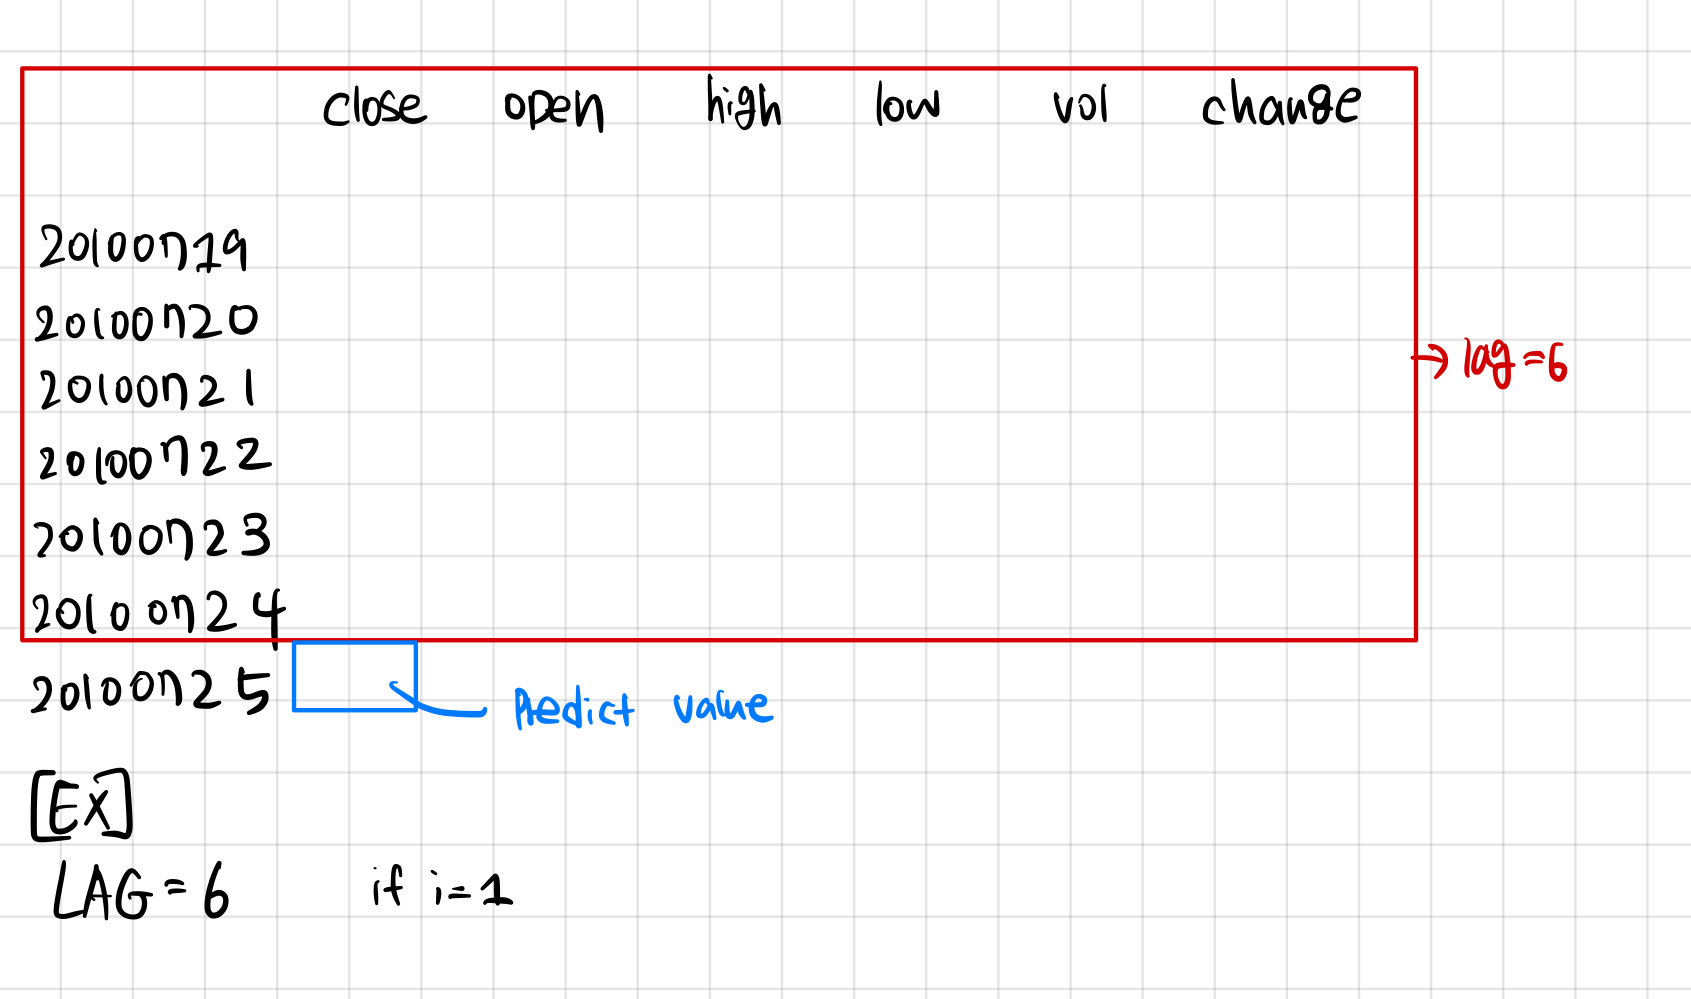

In [ ]:
df_train.iloc[1:7,:]

,close,open,high,low,vol,change,fg_index
date,,,,,,,
2018-02-03,0.005255,-0.004382,0.004586,0.005125,0.000116,0.120328,-0.106280
2018-02-04,-0.015389,0.005329,-0.001873,-0.004875,0.000056,-0.254992,0.106280
2018-02-05,-0.019389,-0.015671,-0.014994,-0.019673,0.000063,-0.078170,0.000000
2018-02-06,0.011520,-0.019675,-0.007310,-0.010070,0.000133,0.454002,0.000000
2018-02-07,-0.001609,0.011584,0.009611,0.018441,0.000198,-0.211128,-0.164251
2018-02-08,0.008602,-0.001515,-0.000699,0.006124,0.000100,0.151562,-0.086957


In [ ]:
df_train.iloc[7,:]

close       0.008090
open        0.008728
high        0.003688
low         0.002912
vol         0.000066
change     -0.016044
fg_index    0.202899
Name: 2018-02-09 00:00:00, dtype: float64

In [ ]:
LAG = 60 # Example: Use the past 60 days to predict the next day

In [ ]:
validation_size = 0.2
n_validation = int(len(df_train) * validation_size)

df_val = df_train.iloc[-n_validation:]
df_train_reduced = df_train.iloc[:-n_validation]

X_train, y_train = generate_dataset(df_train_reduced, LAG)
X_val, y_val = generate_dataset(pd.concat((df_train_reduced.iloc[-LAG:], df_val)), LAG)
X_test, y_test = generate_dataset(pd.concat((df_train.iloc[-LAG:], df_test)), LAG)

### Hyperparameter Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

<ipython-input-122-bf4685511596>:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
def build_model(hp):
    model = Sequential([
        LSTM(
            units=hp.Int('units1', min_value=32, max_value=256, step=32),
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            recurrent_dropout=hp.Float('recurrent_dropout1', min_value=0.0, max_value=0.5, step=0.1)
        ),
        Dropout(rate=hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)),
        LSTM(
            units=hp.Int('units2', min_value=32, max_value=256, step=32),
            recurrent_dropout=hp.Float('recurrent_dropout2', min_value=0.0, max_value=0.5, step=0.1)
        ),
        Dropout(rate=hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
            activation='relu'
        ),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='mse'
    )

    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # Number of different configurations to try
    executions_per_trial=1,  # Number of models to train for each trial
    directory='my_dir',  # Directory to save logs and models
    project_name='lstm_tuning'
)

In [ ]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 8
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
recurrent_dropout1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
recurrent_dropout2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001

In [ ]:
# Perform the hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Trial 20 Complete [00h 00m 25s]
val_loss: 7.530563834734494e-06

Best val_loss So Far: 7.059502877382329e-06
Total elapsed time: 00h 09m 04s


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units1')},
the optimal dropout rates are {best_hps.get('dropout1')} for the first dropout layer and {best_hps.get('dropout2')} for the second dropout layer,
the optimal number of units in the second LSTM layer is {best_hps.get('units2')}, and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 224,
the optimal dropout rates are 0.2 for the first dropout layer and 0.0 for the second dropout layer,
the optimal number of units in the second LSTM layer is 64, and the optimal learning rate for the optimizer
is 0.0001183672101403047.



In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
6/6 [==============================] - 6s 411ms/step - loss: 1.5786e-05 - val_loss: 9.4796e-06
Epoch 2/50
6/6 [==============================] - 2s 341ms/step - loss: 1.4543e-05 - val_loss: 7.7342e-06
Epoch 3/50
6/6 [==============================] - 1s 224ms/step - loss: 1.4326e-05 - val_loss: 8.0467e-06
Epoch 4/50
6/6 [==============================] - 1s 227ms/step - loss: 1.4848e-05 - val_loss: 8.6805e-06
Epoch 5/50
6/6 [==============================] - 1s 227ms/step - loss: 1.4301e-05 - val_loss: 8.1520e-06
Epoch 6/50
6/6 [==============================] - 1s 227ms/step - loss: 1.4660e-05 - val_loss: 7.7904e-06
Epoch 7/50
6/6 [==============================] - 1s 227ms/step - loss: 1.5131e-05 - val_loss: 8.1345e-06
Epoch 8/50
6/6 [==============================] - 1s 224ms/step - loss: 1.4664e-05 - val_loss: 7.5168e-06
Epoch 9/50
6/6 [==============================] - 1s 226ms/step - loss: 1.4449e-05 - val_loss: 8.5059e-06
Epoch 10/50
6/6 [=============================

In [ ]:
predicted_prices = model.predict(X_test)

In [ ]:
# Reshape predicted_prices to match the expected shape
predicted_prices_reshaped = np.zeros((predicted_prices.shape[0], df[columns_to_scale].shape[1]))
predicted_prices_reshaped[:, 0] = predicted_prices[:, 0]  # Assuming the first column is the predicted closing price

# Apply inverse transformation
predicted_prices_original_scale = scaler.inverse_transform(predicted_prices_reshaped)


In [ ]:
predicted_closing_prices = predicted_prices_original_scale[:, 0]

In [ ]:
predicted_closing_prices

array([3288.33506907, 3257.90651267, 3255.68799026, 3266.74615288,
       3239.6894015 , 3248.40212429, 3258.49211078, 3243.54336863,
       3226.90848937, 3204.94513158, 3230.62447375, 3239.83081031,
       3234.72476267, 3259.83518036, 3262.84063298, 3259.43046591,
       3254.67557981, 3225.03044953, 3236.72014026, 3260.29055735,
       3231.93047714, 3289.3956833 , 3278.47646304, 3284.58456202,
       3277.2740392 , 3288.08593783, 3269.0200896 , 3264.94459626,
       3243.42909083, 3257.93387876, 3253.4824206 ])

In [ ]:
print("Test MSE:", np.mean((predicted_closing_prices- y_test)**2))

Test MSE: 10592962.720548945


### Plot the comparison between actual and predicted value

In [ ]:
# y_close_test <- use value before minmax scaling
y_close_test = df_test_plot['close']
LSTM_pred = predicted_closing_prices.copy()

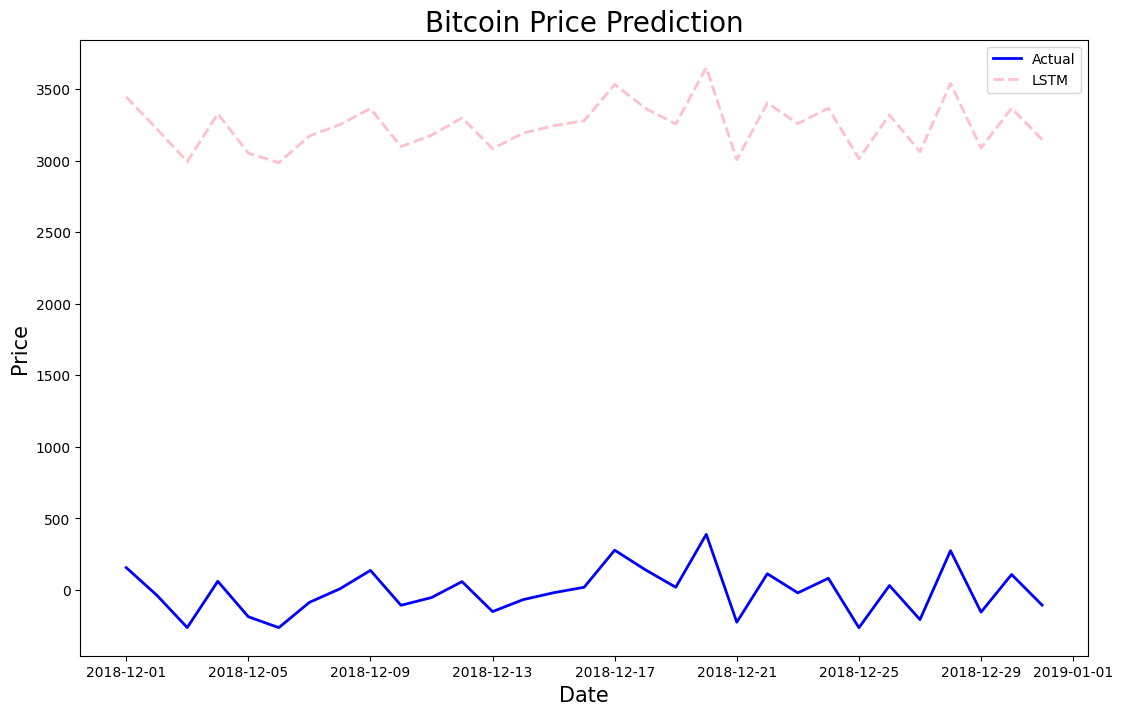

In [ ]:
import matplotlib.pyplot as plt

date_val = pd.to_datetime(y_close_test.index)
LSTM_close = y_close_test + (LSTM_pred - y_test)
fig = plt.figure(figsize=(13,8))
plt.plot(y_close_test, color='blue', linewidth=2, label='Actual')
plt.plot(LSTM_close, color='pink', linestyle='dashed',
linewidth=2, label="LSTM")
plt.title('Bitcoin Price Prediction', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend()

In [ ]:
result = pd.concat([LSTM_close,y_close_test],1)
result.columns = ['predicted', 'actual']
result.head()

<ipython-input-136-580c9332cf07>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  result = pd.concat([LSTM_close,y_close_test],1)


,predicted,actual
date,,
2018-12-01,3444.832705,156.5
2018-12-02,3222.107053,-35.8
2018-12-03,2993.091957,-262.6
2018-12-04,3327.445236,60.7
2018-12-05,3052.792224,-186.9


<ipython-input-136-580c9332cf07>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  result = pd.concat([LSTM_close,y_close_test],1)


,predicted,actual
date,,
2018-12-01,3444.832705,156.5
2018-12-02,3222.107053,-35.8
2018-12-03,2993.091957,-262.6
2018-12-04,3327.445236,60.7
2018-12-05,3052.792224,-186.9
